# Fogify Example - Simple Flask 
This Example code is used to get to know Fogify. Since this the first test/example, the application used is a simple flask application.


***NOTE FOR FUTURE:* Add Raspberry Pi or other small device(s) to replicate user traffic to the Flask App**

## Import FogifySDK, connect with controller, and import "fogified" `docker-compose` file

In [ ]:
from FogifySDK import FogifySDK
fogify = FogifySDK("http://controller:5000", "docker-compose.yaml")

## Deploy the topology
While the system deploys the topology, a progress bar illustrates the current status.

In [ ]:
fogify.deploy()

Deploy process: 100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


{'message': "The services are deployed ( {'cloud-server': 1, 'mec-svc-1': 1, 'mec-svc-2': 1, 'car-workload-1': 2, 'car-workload-2': 1} )"}

In [ ]:
fogify.command(instance_type='user-workload-1', command="k6 run /scripts/k6-script.js --out xk6-influxdb --out json=test.json", num_of_instances=1)

In [ ]:
%%html
<iframe width="1200" height="500" src="http://192.168.1.1:3000/d/c308c7ab-1bef-47e6-a3ac-ab660b24cb09/k6-load-testing-results?orgId=1&refresh=5s&from=1705260187697&to=1705263787697" allowfullscreen></iframe>

## Retrieve the monitoring metrics from running instances
Fogify allows users to retrieve monitoring metrics in `pandas` dataframes.
The latter helps in depicting:

### Tables of values

In [ ]:
fogify.get_metrics_from('edge-svc-1.1')

,count,memory_util,cpu,cpu_util,memory,network_rx_internet,network_tx_internet,network_rx_edge-net-1,network_tx_edge-net-1
timestamp,,,,,,,,,
2020-09-17 12:24:44,3,0.022070,1.030282e+09,0.000000,47394816.0,0.0,0.0,0.0,0.0
2020-09-17 12:24:51,4,0.022070,1.089237e+09,0.645380,47394816.0,0.0,0.0,0.0,0.0
2020-09-17 12:24:58,5,0.022375,1.681259e+09,5.587496,48050176.0,0.0,0.0,95342.0,80682.0
2020-09-17 12:25:03,6,0.022707,2.549128e+09,10.045213,48762880.0,1188.0,22516.0,176926.0,149736.0
2020-09-17 12:25:08,7,0.022732,2.973427e+09,6.034867,48816128.0,1188.0,22516.0,231297.0,195816.0


### Summaries

In [ ]:
fogify.get_metrics_from('edge-svc-1.1').describe()

,count,memory_util,cpu,cpu_util,memory,network_rx_internet,network_tx_internet,network_rx_edge-net-1,network_tx_edge-net-1
count,6.000000,6.000000,6.000000e+00,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000
mean,5.500000,0.022471,2.145384e+09,4.827603,4.825634e+07,594.000000,11258.000000,136073.500000,115195.000000
std,1.870829,0.000351,1.038559e+09,3.831082,7.538539e+05,650.694398,12332.521105,127032.763972,107560.324118
min,3.000000,0.022070,1.030282e+09,0.000000,4.739482e+07,0.000000,0.000000,0.000000,0.000000
25%,4.250000,0.022146,1.237243e+09,1.880909,4.755866e+07,0.000000,0.000000,23835.500000,20170.500000
50%,5.500000,0.022541,2.115194e+09,5.811181,4.840653e+07,594.000000,11258.000000,136134.000000,115209.000000
75%,6.750000,0.022726,2.867353e+09,6.498215,4.880282e+07,1188.000000,22516.000000,217704.250000,184296.000000
max,8.000000,0.022873,3.548967e+09,10.045213,4.911923e+07,1188.000000,22516.000000,312876.000000,264936.000000


## Undeploy
Finally, the FogifySDK provides the `undeploy` method that destroys the emulated infrastructure.

In [ ]:
fogify.undeploy()

### Timelines

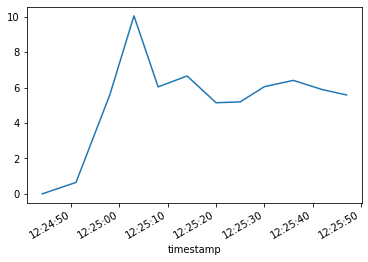

In [ ]:
fogify.get_metrics_from('mec-svc-1.1').cpu_util.plot()

### Distributions

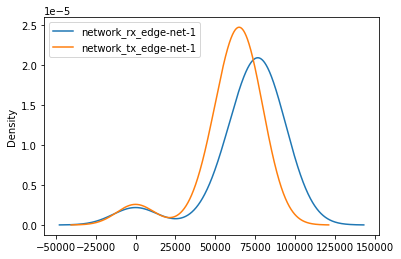

In [ ]:
data = fogify.get_metrics_from('mec-svc-1.1')
data[['network_rx_edge-net-1', 'network_tx_edge-net-1']].diff().plot.kde()

### Scatter plots

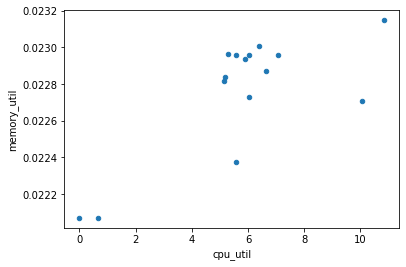

In [ ]:
fogify.get_metrics_from('mec-svc-1.1').plot.scatter('cpu_util', 'memory_util')

## Ad-hoc Actions

With ad-hoc actions, users are able to alternate the running fog topology. Specifically, they can inject network alterations, scaling actions, workload interferences, and arbitrary commands.

For instance, the following method injects a 25% `cpu` intensive workload on the `cloud-server` emulated instance for an one-minute duration (default).

In [ ]:
fogify.stress('cloud-server.1', cpu=25)

{'message': 'OK'}

After that, let's retrieve the CPU utilization to evaluate if the action was injected.

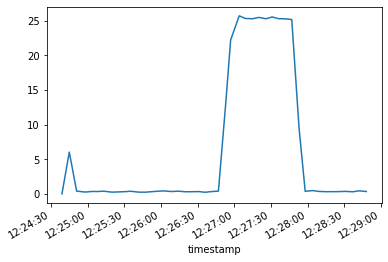

In [ ]:
fogify.get_metrics_from('cloud-server.1').cpu_util.plot()

## Scenarios
A scenario is a sequence of timestamped actions that the Fogify will execute.
The scenarios are described in `docker-compose` file under the `scenarios` section.
To execute a scenario, Fogify requires only the scenario's name (at the following example `scenario_1`).

In [ ]:
start, end = fogify.scenario_execution('scenario_1')

  0%|          | 0/130 [00:00<?, ?it/s]

Scenario execution process: 


 23%|██▎       | 30/130 [00:30<01:40,  1.00s/it]

The action network is executed.


 38%|███▊      | 50/130 [00:50<01:20,  1.00s/it]

The action network is executed.


 62%|██████▏   | 80/130 [01:21<00:50,  1.00s/it]

The action network is executed.


 77%|███████▋  | 100/130 [01:41<00:30,  1.00s/it]

The action network is executed.


100%|██████████| 130/130 [02:12<00:00,  1.02s/it]


The action  is executed.
Scenario is finished


## Scenarios analysis and more complex plot examples

After the scenario's execution users retrieve the generated data by filtering by scenario's time-range. Furthermore, Fogify provides the timestamp of the events and a user is able to combine them.
In the following example, user retrieves the data of `mec-svc-1` service, generates the edge `network-out` and `network-in` timelines, 
and, also, depicts the timestamp ( *vertical lines* ) of the scenario's actions.

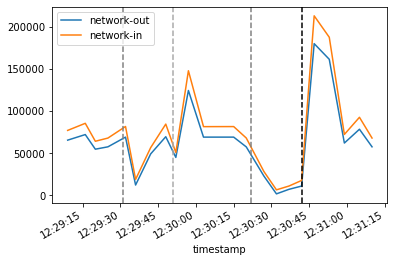

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()

data = fogify.get_metrics_from('mec-svc-1.1')
data = data[data.index>start]
data = data[data.index<end]

data['network_tx_edge-net-1'].diff().plot(ax=ax,label="network-out")
data['network_rx_edge-net-1'].diff().plot(ax=ax,label="network-in")
ax.legend()
fogify.plot_annotations(ax, start=start, stop=end, colors_gist=['gray','darkgray', 'gray', 'black'])

Similarly, the user generates the CPU utilization plot of the first instance of `car-workload-1` service. 

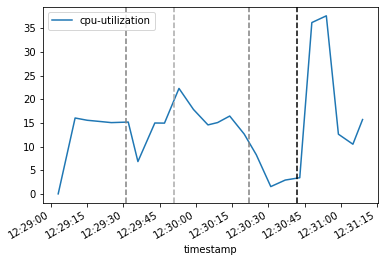

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots()

data = fogify.get_metrics_from('car-workload-1.1')
data = data[data.index>start]
data = data[data.index<end]

data['cpu_util'].plot(ax=ax,label="cpu-utilization")
ax.legend()
fogify.plot_annotations(ax, start=start, stop=end, colors_gist=['gray','darkgray', 'gray', 'black'])

Moreover, the user generates a scatter plot ( *cpu utilization* vs *network traffic* of `mec-svc-1`)  with points only from the period of scenario execution.

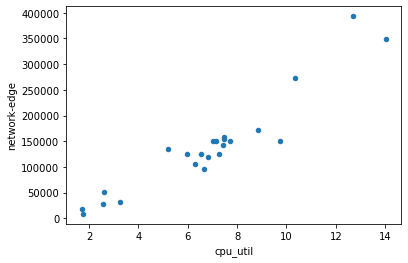

In [ ]:
data = fogify.get_metrics_from('mec-svc-1.1')
data = data[data.index>start]
data = data[data.index<end]
data['network-edge'] = data['network_tx_edge-net-1'].diff() + data['network_rx_edge-net-1'].diff()
data.plot.scatter('cpu_util', 'network-edge' )

## Undeploy
Finally, the FogifySDK provides the `undeploy` method that destroys the emulated infrastructure.

In [ ]:
fogify.undeploy()

Undeploy process: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s]


{'message': 'The 6 services are undeployed'}